# Spatial and temporal subsetting 

A common task in climate data analysis is subsetting files over a region of interest. Global model simulations and observations cover the entire globe, while impact analyses are often concerned with a region. Instead of downloading the entire file on a local disk, it is often more practical to subset it on the server and only download the relevant part. 

This can be done through two ways: interactive analysis using OPeNDAP, or a WPS request for a subsetter. Let's start with the most direct approach with OPeNDAP. The PAVICS THREDDS server provides two links for each file, a link to the file itself which will download the file locally when accessed, and a *dodsC* link which supports the OPeNDAP protocol. We'll use this link and simply pass it to our netCDF library, here `xarray`. 

## Subsetting with OPeNDAP

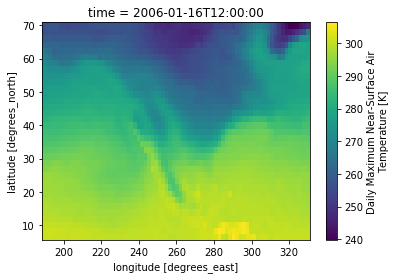

In [1]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

verify_ssl = True if 'DISABLE_VERIFY_SSL' not in os.environ else False

# The dodsC link for the test file
dap = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/'
ncfile = 'birdhouse/testdata/flyingpigeon/cmip5/tasmax_Amon_MPI-ESM-MR_rcp45_r1i1p1_200601-200612.nc'

# Here we open the file and subset it using xarray fonctionality, which communicates directly with 
# the OPeNDAP server to retrieve only the data needed. 
ds = xr.open_dataset(dap+ncfile)
tas = ds.tasmax
subtas = tas.sel(time=slice('2006-01-01', '2006-03-01'), lon=slice(188,330), lat=slice(6, 70))
subtas.isel(time=0).plot()
plt.show()

## Subset processes with WPS and FlyingPigeon

PAVICS offers a number of subsetting processes through the FlyingPigeon WPS server:
 - subset_continents
 - subset_countries
 - subset_bbox
 - subset_wfs
 - subset
 
The `subset_continents` and `subset_countries` use a predefined list of polygons for the subsetting. The `subset_bbox` takes the geographical coordinates of the two opposite corner of a rectangle to define the subset region, while both `subset_wfs` and `subset` use a polygon defined on a remote geoserver, identified by a typename and a feature id. The only difference between those two is that `subset` also does temporal subsetting. 

The first step to launch those services is to create a connexion to the WPS server using Birdy's `WPSClient`. 

In [2]:
from birdy import WPSClient
url = 'https://pavics.ouranos.ca/twitcher/ows/proxy/flyingpigeon/wps'
fp = WPSClient(url, verify=verify_ssl)

Now we'll use `fp.subset_continents`, so let's first check what arguments it expects and pass those to the function.

In [3]:
help(fp.subset_continents)

Help on method subset_continents in module birdy.client.base:

subset_continents(resource=None, region='Africa', mosaic=None) method of birdy.client.base.WPSClient instance
    Return the data whose grid cells intersect the selected continents for each input dataset.
    
    Parameters
    ----------
    region : {'Africa', 'Asia', 'Australia', 'North America', 'Oceania', 'South America', 'Antarctica', 'Europe'}string
        Continent name.
    mosaic : boolean
        If True, selected regions will be merged into a single geometry.
    resource : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-tar`, :mimetype:`application/zip`
        NetCDF Files or archive (tar/zip) containing netCDF files.
    
    Returns
    -------
    output : ComplexData:mimetype:`application/x-tar`
        Tar archive of the subsetted netCDF files.
    ncout : ComplexData:mimetype:`application/x-netcdf`
        NetCDF file with subset for one dataset.
    output_log : ComplexData:mimet

In [4]:
thredds = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/fileServer/'
ncfile = 'birdhouse/testdata/flyingpigeon/cmip5/tasmax_Amon_MPI-ESM-MR_rcp45_r1i1p1_200601-200612.nc'
resp = fp.subset_continents(resource=thredds+ncfile, region='Africa')

ServiceException: Maximum number of parallel running processes reached. Please try later.

The response we're getting can either include the data itself or a reference to the data. Using the `get` method of the response object, we'll get what was included in the response. If the response holds only a reference (link) to the output, we can retrieve it using the `get(as_obj=True)` method. Birdy will then inspect the file format of each output and try to find the appropriate way to open the file and return a Python object. A warning is issued if no converter is found, in which case the original reference is returned.

In [5]:
resp.get(verify=verify_ssl)
tar_out, nc_out, log = resp.get(asobj=True, verify=verify_ssl)

NameError: name 'resp' is not defined

Next, we'll open the netCDF dataset using xarray and plot the result. Note that since nc_out is an already opened netcdf4.Dataset, we're using the `xr.backends.NetCDF4DataStore` function to open the dataset. 

In [6]:
import xarray as xr
ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_out))
ds.tasmax.isel(time=0).plot()

NameError: name 'nc_out' is not defined